In [1]:
# Complete imports and matplotlib setup
import matplotlib
matplotlib.use('Agg')  # Use non-interactive backend first
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import cv2
import os
import sys

# Set up matplotlib for static plots (no JavaScript dependencies)
%matplotlib inline

print("All imports loaded successfully")
print("Matplotlib backend:", matplotlib.get_backend())

All imports loaded successfully
Matplotlib backend: inline


In [2]:
def set_up_cameras():
    """Set up camera matrices and positions."""
    print("\n=== SETTING UP CAMERAS ===", flush=True)
    
    # Camera intrinsic matrices (same for both cameras)
    K = np.array([
        [1000, 0, 640],
        [0, 1000, 360], 
        [0, 0, 1]
    ], dtype=np.float64)
    
    # Camera 1: At origin, raised in Z
    R1 = np.eye(3, dtype=np.float64)
    t1 = np.array([[0.0], [0.0], [2.5]], dtype=np.float64)
    
    # Camera 2: Translated along X axis, raised in Z  
    R2 = np.eye(3, dtype=np.float64)
    t2 = np.array([[1.0], [0.0], [2.5]], dtype=np.float64)
    
    # Camera positions for plotting
    cam1_pos = t1.flatten()
    cam2_pos = t2.flatten()
    
    print(f"Camera 1 position: {cam1_pos}")
    print(f"Camera 2 position: {cam2_pos}")
    
    # Projection matrices P = K[R|t]
    P1 = K @ np.hstack((R1, t1))
    P2 = K @ np.hstack((R2, t2))
    
    return P1, P2, cam1_pos, cam2_pos

In [3]:
def plot_camera(ax, camera_pos, color, label, boresight_length=3.0):
    """Plot a camera in 3D space with frustum and boresight line of sight."""
    print(f"Plotting camera: {label} at position {camera_pos}")
    
    # Plot camera position with a large marker
    ax.scatter(camera_pos[0], camera_pos[1], camera_pos[2], 
              color=color, marker='*', s=1000, label=label,
              edgecolor='black', linewidth=2.0)
    
    # Add a vertical stem line from ground to camera
    ax.plot([camera_pos[0], camera_pos[0]], 
            [camera_pos[1], camera_pos[1]], 
            [0, camera_pos[2]], 
            color=color, linewidth=4.0, alpha=0.7)
    
    # Add text label with coordinates
    ax.text(camera_pos[0], camera_pos[1], camera_pos[2] + 0.3,
            f"{label}\n({camera_pos[0]:.1f}, {camera_pos[1]:.1f}, {camera_pos[2]:.1f})",
            color=color, fontsize=10, weight='bold', ha='center')
    
    # Define boresight direction (looking forward and down at 45 degrees)
    elevation_angle = -45  # degrees
    azimuth_angle = 0  # degrees
    
    # Convert angles to direction vector
    elevation_rad = np.radians(elevation_angle)
    azimuth_rad = np.radians(azimuth_angle)
    
    boresight_dir = np.array([
        np.cos(elevation_rad) * np.sin(azimuth_rad),
        np.cos(elevation_rad) * np.cos(azimuth_rad),
        np.sin(elevation_rad)
    ])
    
    # Normalize the direction vector
    boresight_dir = boresight_dir / np.linalg.norm(boresight_dir)
    
    # Calculate boresight end point
    boresight_end = camera_pos + boresight_dir * boresight_length
    
    # Draw boresight line of sight
    ax.plot([camera_pos[0], boresight_end[0]],
            [camera_pos[1], boresight_end[1]],
            [camera_pos[2], boresight_end[2]],
            color=color, linewidth=2.0, linestyle='--',
            alpha=0.7)
    
    print(f"Camera {label} plotted successfully")

In [4]:
def generate_synthetic_tracks():
    """Generate synthetic 3D track and project to 2D camera views."""
    # Get camera matrices
    P1, P2, _, _ = set_up_cameras()
    
    print("\n=== GENERATING SYNTHETIC TRACKS ===", flush=True)
    
    # Define a 3D trajectory (moving object)
    original_3d = [
        np.array([0.2, 0.5, 3.0]),
        np.array([0.3, 0.5, 2.9]), 
        np.array([0.4, 0.5, 2.8]),
        np.array([0.5, 0.5, 2.7]),
        np.array([0.6, 0.5, 2.6])
    ]
    
    sensor1_track = []
    sensor2_track = []
    
    for i, point_3d in enumerate(original_3d):
        print(f"Processing point {i}: {point_3d}")
        
        # Convert to homogeneous coordinates
        point_3d_h = np.append(point_3d, 1.0)
        
        # Project to camera 1
        proj1 = P1 @ point_3d_h
        if abs(proj1[2]) > 1e-10:  # Check for valid depth
            pixel1 = proj1[:2] / proj1[2]
        else:
            print(f"Warning: Invalid depth for camera 1 at point {i}")
            pixel1 = np.array([np.inf, np.inf])
        
        # Project to camera 2  
        proj2 = P2 @ point_3d_h
        if abs(proj2[2]) > 1e-10:  # Check for valid depth
            pixel2 = proj2[:2] / proj2[2]
        else:
            print(f"Warning: Invalid depth for camera 2 at point {i}")
            pixel2 = np.array([np.inf, np.inf])
        
        sensor1_track.append(pixel1)
        sensor2_track.append(pixel2)
        
        print(f"  Camera 1 pixel: {pixel1}")
        print(f"  Camera 2 pixel: {pixel2}")
    
    # Convert to numpy arrays
    sensor1_track = np.array(sensor1_track)
    sensor2_track = np.array(sensor2_track)
    original_3d = np.array(original_3d)
    
    print(f"\nGenerated tracks:")
    print(f"Sensor 1 track shape: {sensor1_track.shape}")
    print(f"Sensor 2 track shape: {sensor2_track.shape}")
    print(f"Original 3D shape: {original_3d.shape}")
    
    return sensor1_track, sensor2_track, original_3d

In [5]:
def triangulate_tracks(sensor1_track, sensor2_track, P1, P2):
    """Triangulate 3D points from 2D tracks from two cameras."""
    points_3d = []
    
    for pt1, pt2 in zip(sensor1_track, sensor2_track):
        # Skip invalid points
        if not (np.isfinite(pt1[0]) and np.isfinite(pt1[1]) and 
                np.isfinite(pt2[0]) and np.isfinite(pt2[1])):
            print(f"Skipping invalid points: {pt1}, {pt2}")
            points_3d.append(np.array([np.nan, np.nan, np.nan]))
            continue
            
        # Reshape points for OpenCV triangulation
        p1 = np.array(pt1, dtype=np.float32).reshape(2, 1)
        p2 = np.array(pt2, dtype=np.float32).reshape(2, 1)
        
        # Triangulate the point
        point_homog = cv2.triangulatePoints(P1, P2, p1, p2)
        
        # Convert from homogeneous coordinates
        if abs(point_homog[3]) > 1e-10:
            point_3d = (point_homog[:3] / point_homog[3]).flatten()
        else:
            point_3d = np.array([np.nan, np.nan, np.nan])
            
        points_3d.append(point_3d)
    
    return np.array(points_3d)

In [6]:
# Test all functions
print("Testing camera setup...")
P1, P2, cam1_pos, cam2_pos = set_up_cameras()

print("\nTesting track generation...")
sensor1_track, sensor2_track, original_3d = generate_synthetic_tracks()

print("\nTesting triangulation...")
reconstructed_3d = triangulate_tracks(sensor1_track, sensor2_track, P1, P2)

print("\n=== ALL FUNCTIONS READY ===")
print("You can now run the visualization cells!")

Testing camera setup...

=== SETTING UP CAMERAS ===
Camera 1 position: [0.  0.  2.5]
Camera 2 position: [1.  0.  2.5]

Testing track generation...

=== SETTING UP CAMERAS ===
Camera 1 position: [0.  0.  2.5]
Camera 2 position: [1.  0.  2.5]

=== GENERATING SYNTHETIC TRACKS ===
Processing point 0: [0.2 0.3 3. ]
  Camera 1 pixel: [676.36363636 414.54545455]
  Camera 2 pixel: [858.18181818 414.54545455]
Processing point 1: [0.3 0.4 2.9]
  Camera 1 pixel: [695.55555556 434.07407407]
  Camera 2 pixel: [880.74074074 434.07407407]
Processing point 2: [0.4 0.5 2.8]
  Camera 1 pixel: [715.47169811 454.33962264]
  Camera 2 pixel: [904.1509434  454.33962264]
Processing point 3: [0.5 0.6 2.7]
  Camera 1 pixel: [736.15384615 475.38461538]
  Camera 2 pixel: [928.46153846 475.38461538]
Processing point 4: [0.6 0.7 2.6]
  Camera 1 pixel: [757.64705882 497.25490196]
  Camera 2 pixel: [953.7254902  497.25490196]

Generated tracks:
Sensor 1 track shape: (5, 2)
Sensor 2 track shape: (5, 2)
Original 3D sha


=== SETTING UP CAMERAS ===
Camera 1 position: [0.  0.  2.5]
Camera 2 position: [1.  0.  2.5]
Plotting camera: Camera 1 at position [0.  0.  2.5]
Camera Camera 1 plotted successfully
Plotting camera: Camera 2 at position [1.  0.  2.5]
Camera Camera 2 plotted successfully


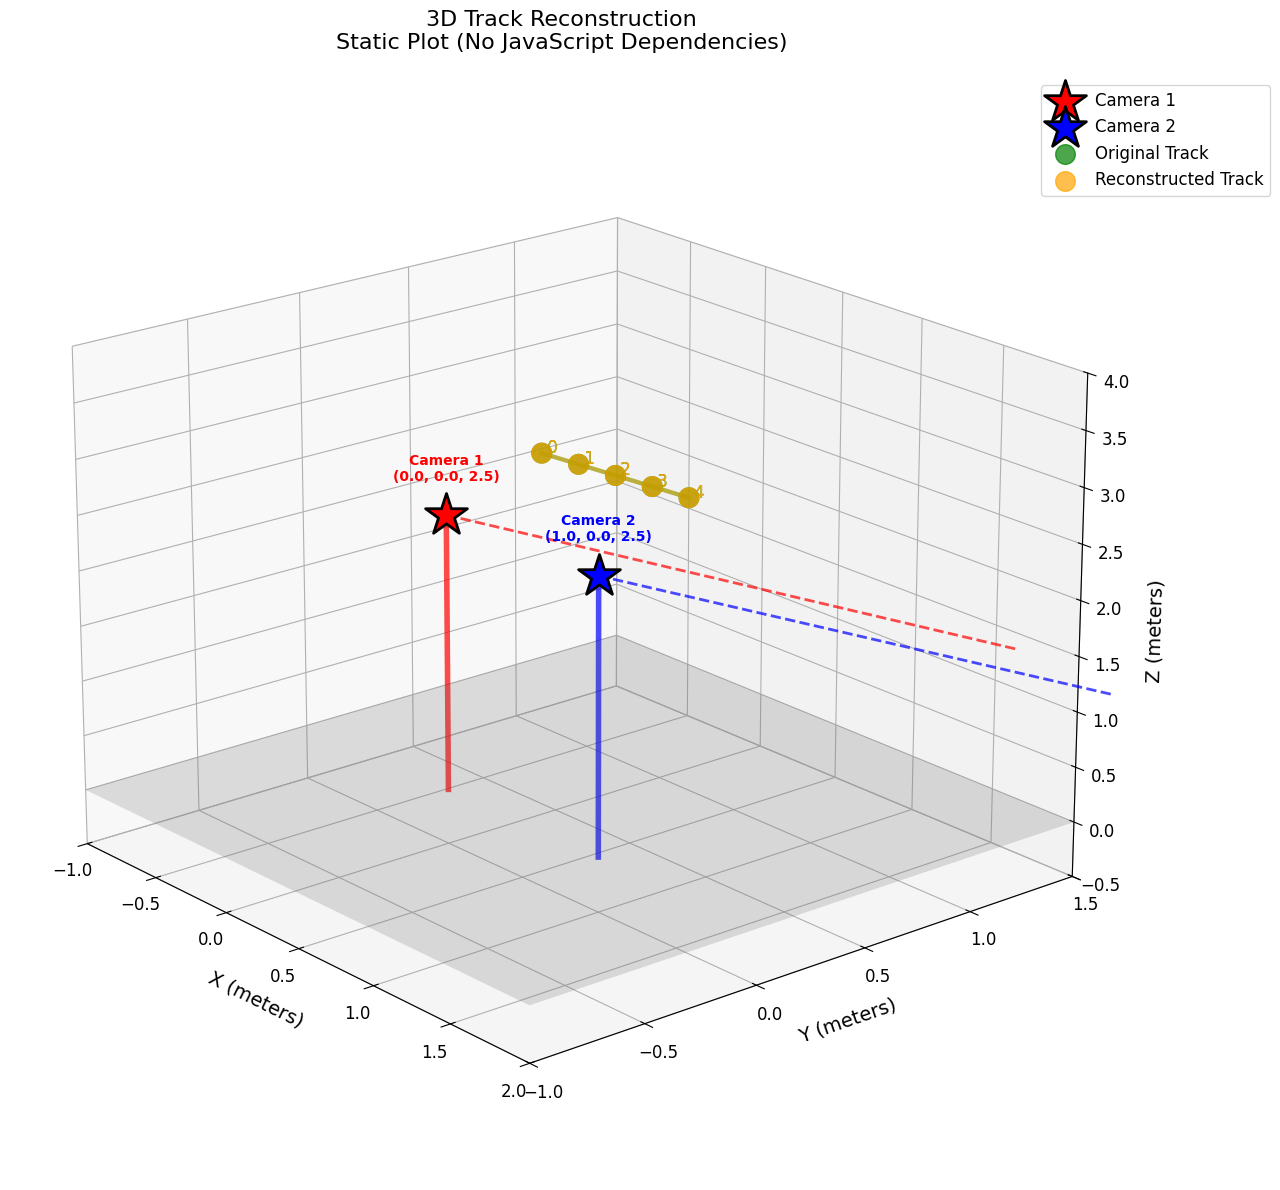


3D visualization complete!


In [7]:
# Create a large figure for better interaction
plt.figure(figsize=(16, 12))
ax = plt.axes(projection='3d')

# Set consistent view limits with more space
ax.set_xlim(-1.0, 2.0)
ax.set_ylim(-1.0, 1.5)
ax.set_zlim(-0.5, 4.0)

# Enable grid for better spatial reference
ax.grid(True, linestyle='--', alpha=0.6)

# Plot ground plane
xx, yy = np.meshgrid(np.linspace(-1.0, 2.0, 20), np.linspace(-1.0, 1.5, 20))
zz = np.zeros_like(xx)
ax.plot_surface(xx, yy, zz, alpha=0.2, color='gray')

# Plot trajectory constraint plane (y = 0.5)
xx_plane, zz_plane = np.meshgrid(np.linspace(-1.0, 2.0, 20), np.linspace(-0.5, 4.0, 20))
yy_plane = np.full_like(xx_plane, 0.5)
ax.plot_surface(xx_plane, yy_plane, zz_plane, alpha=0.1, color='yellow', label='Trajectory Plane (y=0.5)')

# Get camera positions
_, _, cam1_pos, cam2_pos = set_up_cameras()

# Plot cameras with increased boresight length for clarity
plot_camera(ax, cam1_pos, 'red', 'Camera 1', boresight_length=4.0)
plot_camera(ax, cam2_pos, 'blue', 'Camera 2', boresight_length=4.0)

# Plot all 3D points with increased size and better visibility
ax.scatter(
    [p[0] for p in original_3d],
    [p[1] for p in original_3d],
    [p[2] for p in original_3d],
    color='green', label='Original Track', s=200, alpha=0.7
)

# Only plot valid reconstructed points
valid_mask = ~np.isnan(reconstructed_3d[:, 0])
if np.any(valid_mask):
    ax.scatter(
        reconstructed_3d[valid_mask, 0],
        reconstructed_3d[valid_mask, 1],
        reconstructed_3d[valid_mask, 2],
        color='orange', label='Reconstructed Track', s=200, alpha=0.7
    )

# Add trajectory lines with increased thickness
ax.plot(
    [p[0] for p in original_3d],
    [p[1] for p in original_3d],
    [p[2] for p in original_3d],
    'g-', linewidth=3, alpha=0.5
)

if np.any(valid_mask):
    ax.plot(
        reconstructed_3d[valid_mask, 0],
        reconstructed_3d[valid_mask, 1],
        reconstructed_3d[valid_mask, 2],
        color='orange', linewidth=3, alpha=0.5
    )

# Add frame numbers next to points
for i, orig in enumerate(original_3d):
    ax.text(orig[0], orig[1], orig[2], f' {i}', color='green', fontsize=12)

if np.any(valid_mask):
    for i, recon in enumerate(reconstructed_3d[valid_mask]):
        ax.text(recon[0], recon[1], recon[2], f' {i}', color='orange', fontsize=12)

# Set labels with increased size
ax.set_xlabel('X (meters)', fontsize=14, labelpad=10)
ax.set_ylabel('Y (meters)', fontsize=14, labelpad=10)
ax.set_zlabel('Z (meters)', fontsize=14, labelpad=10)

# Increase tick label size
ax.tick_params(axis='both', which='major', labelsize=12)

# Add title
plt.title('3D Track Reconstruction\nStatic Plot (No JavaScript Dependencies)', 
          fontsize=16, pad=20)

# Move legend outside the plot
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', fontsize=12)

# Set consistent view angle
ax.view_init(elev=20, azim=-40)

plt.tight_layout()
plt.show()

print("\n3D visualization complete!")